# [CoE202] note 11c. DQN : cartpole (with visualization)
- Class Date : 21.06.10.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

1. Here, we are going to repeat what we did in 11b.
The difference is that we are going to add visualization parts.
This will make the code long and the core part will not change at all.

2. As usual, let's start with importing libraries!

In [28]:
import random 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F

import gym                                    # this is for RL environment (https://gym.openai.com/)
from collections import deque               # this simplifies the implementation of the replay buffer

3. Let's specify the environment.
We are going to use CartPole from OPENAI (https://gym.openai.com/)

In [29]:
# gym environment
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)

4. We need a bunch of stuff for visualization (as we are running on server without a physical display!)

In [30]:
!apt-get install -y xvfb python-opengl x11-utils
!pip install gym==0.17.2 pyvirtualdisplay==0.2.5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
python-opengl is already the newest version (3.1.0+dfsg-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


5. We also need wrapper for Xvfb, Xephyr and Xvnc (Let's not worry about this).

In [31]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

6. Let's important some more libraries...(for visualization).

In [32]:
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

7. Here's our function for visualization of the result.

In [33]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

8. Let's define our Q-network.

In [34]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 48)     # four-dimensional observation ([position of cart, velocity of cart, angle of pole, rotation rate of pole])
        self.fc1 = nn.Linear(48, 64)   # hidden layer
        self.fc2 = nn.Linear(64, 2)    # two possible actions (left-right)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

9. Define a function for updating our Q-network.

In [35]:
def update_Q():

    loss = 0
    for state, action, state_next, reward, done in random.sample(history, min(32, len(history))):
        with torch.no_grad():
            if done:
                target = reward
            else:
                target = reward + discount * torch.max(Q_target(state_next))

        loss = loss + (target - Q(state)[action])**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

10. Here are our hyper-parameters.




In [36]:
buffer_size = 1000000   # size of replay buffer
discount = 0.99         # discount factor gamma
max_time_steps = 200    # maximum episode length
target_interval = 1000  # we will update target network every THIS updates


reward_recent_history = deque(maxlen=30)  # for computing average reward over 30 episodes

11. Here's our replay buffer. deque function makes it very easy to implement :)

In [37]:
history = deque(maxlen=buffer_size) # replay buffer

12. Let's initialize our networks (Q-network & target network).

In [38]:
# network and optimizer
Q = QNetwork()
optimizer = torch.optim.Adam(Q.parameters(), lr=0.0005)

# target network
Q_target = QNetwork()

13. Test the performance of the untrained network!

In [39]:
# TEST (with untrained Q-network)
env_vis = wrap_env(gym.make(ENV_NAME))
observation = env_vis.reset()

rewards = 0

while True:
  
    #env.render()    
    state = torch.tensor(observation, dtype=torch.float32)
    action = torch.argmax(Q(state)).item()       
    observation, reward, done, info = env_vis.step(action) 
    rewards = rewards + reward        
    if done: 
      break;
            
env_vis.close()
show_video()
print("Total reward is " + str(rewards) + ".")

Total reward is 21.0.


14. Define a function to keep track of the performance.

In [40]:
def plt_history():
    clear_output(True)
    plt.figure(figsize=[16, 9])
    plt.subplot(1, 2, 1)
    plt.title("Reward history")
    plt.plot(reward_history)
    plt.grid()

    plt.show()

15. Let's start training!

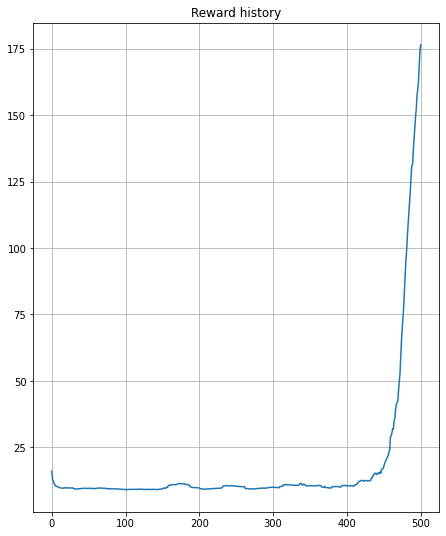

Early stopping as the exit condition is met.


In [41]:
target_counter = 0      # counter initialization
reward_history = []

# training
for episode in range(1000):
    # sum of accumulated rewards
    rewards = 0

    # get initial observation
    observation = env.reset()
    state = torch.tensor(observation, dtype=torch.float32)

    # loop until an episode ends
    for t in range(1, max_time_steps + 1):
        # display current environment
        #env.render()

        # epsilon greedy policy for current observation
        with torch.no_grad():
            if random.random() < 0.003:
                action = env.action_space.sample()
            else:
                action = torch.argmax(Q(state)).item()

        # proceed one step (in the environment) 
        observation_next, reward, done, info = env.step(action)
        state_next = torch.tensor(observation_next, dtype=torch.float32)

        # collect reward
        rewards = rewards + reward

        # collect a transition, put it in the replay buffer
        history.append([state, action, state_next, reward, done]) # SASR is added to the buffer

        # perform update 
        update_Q()

        # update target network
        target_counter = target_counter + 1
        if target_counter % target_interval == 0:
            Q_target.load_state_dict(Q.state_dict())

        if done:
            break

        # pass observation to the next step
        observation = observation_next
        state = state_next

    # compute average reward
    reward_recent_history.append(rewards)
    recent_average_reward = np.mean(reward_recent_history)
    reward_history.append(recent_average_reward)

    if episode%10 == 0:
        plt_history()
    
    if recent_average_reward > 0.9*max_time_steps:
        print("Early stopping as the exit condition is met.")
        break

env.close()

16. Let's see the performance after training.

In [42]:
# TEST (with trained Q-network)
env_vis = wrap_env(gym.make(ENV_NAME))
observation = env_vis.reset()
rewards = 0

while True:
  
    #env.render()    
    state = torch.tensor(observation, dtype=torch.float32)
    action = torch.argmax(Q(state)).item()       
    observation, reward, done, info = env_vis.step(action) 
    rewards = rewards + reward        
    if done: 
      break;
            
env_vis.close()
show_video()
print("Total reward is " + str(rewards) + ".")

Total reward is 162.0.
